In [30]:
from folktables import ACSDataSource, ACSEmployment, ACSIncome, ACSHealthInsurance

data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(download=True)
ACSIncome.df_to_pandas(acs_data)[0]

,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P
0,18.0,1.0,18.0,5.0,4720.0,13.0,17.0,21.0,2.0,2.0
1,53.0,5.0,17.0,5.0,3605.0,18.0,16.0,40.0,1.0,1.0
2,41.0,1.0,16.0,5.0,7330.0,1.0,17.0,40.0,1.0,1.0
3,18.0,6.0,18.0,5.0,2722.0,1.0,17.0,2.0,2.0,1.0
4,21.0,5.0,19.0,5.0,3870.0,12.0,17.0,50.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
1664495,39.0,6.0,16.0,5.0,6260.0,72.0,0.0,20.0,1.0,1.0
1664496,38.0,6.0,14.0,5.0,4251.0,72.0,0.0,32.0,1.0,8.0
1664497,37.0,1.0,19.0,3.0,7750.0,17.0,13.0,40.0,2.0,9.0
1664498,47.0,1.0,16.0,1.0,8990.0,72.0,1.0,40.0,1.0,8.0


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import matplotlib
# params = {'axes.titlesize':'18',
#           'xtick.labelsize':'16',
#           'ytick.labelsize':'16',
#           'font.size':'19',
#           'legend.fontsize':'medium',
#           'lines.linewidth':'2.5',
#           'font.weight':'normal',
#           'lines.markersize':'14',
#           'text.latex.preamble': r'\usepackage{amsfonts}',
#           'lines.markerfacecolor':'none'
#           }
# matplotlib.rcParams.update(params)
plt.rcParams["mathtext.fontset"] = "cm"
plt.rc('text', usetex=False)
plt.rc('font', family='serif')
markers = ['s', 'd', 'X', 'o', 'v', '*', '^', '8', 'h', '+']
import config_experiments as cfg

c:\Users\hhwangar\AppData\Local\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


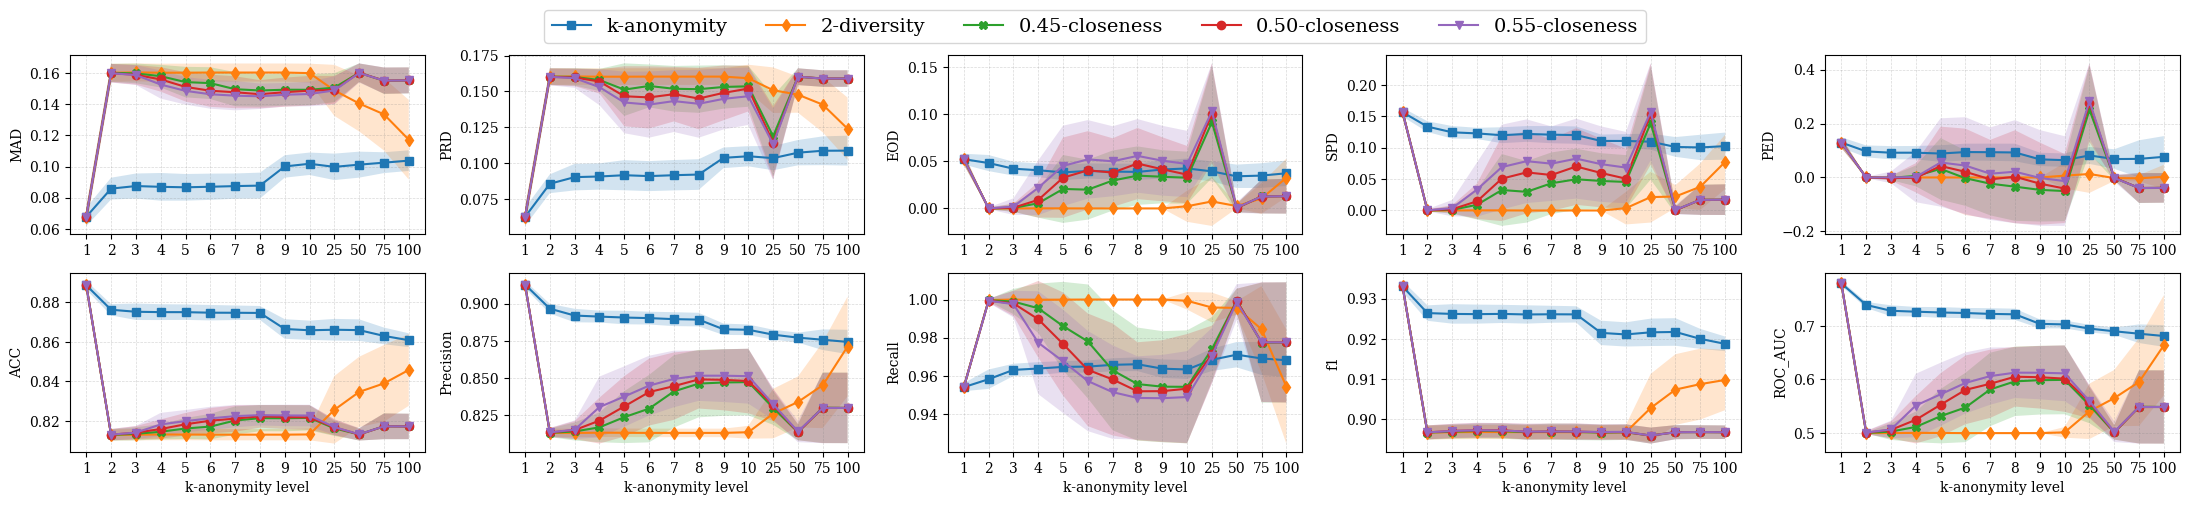

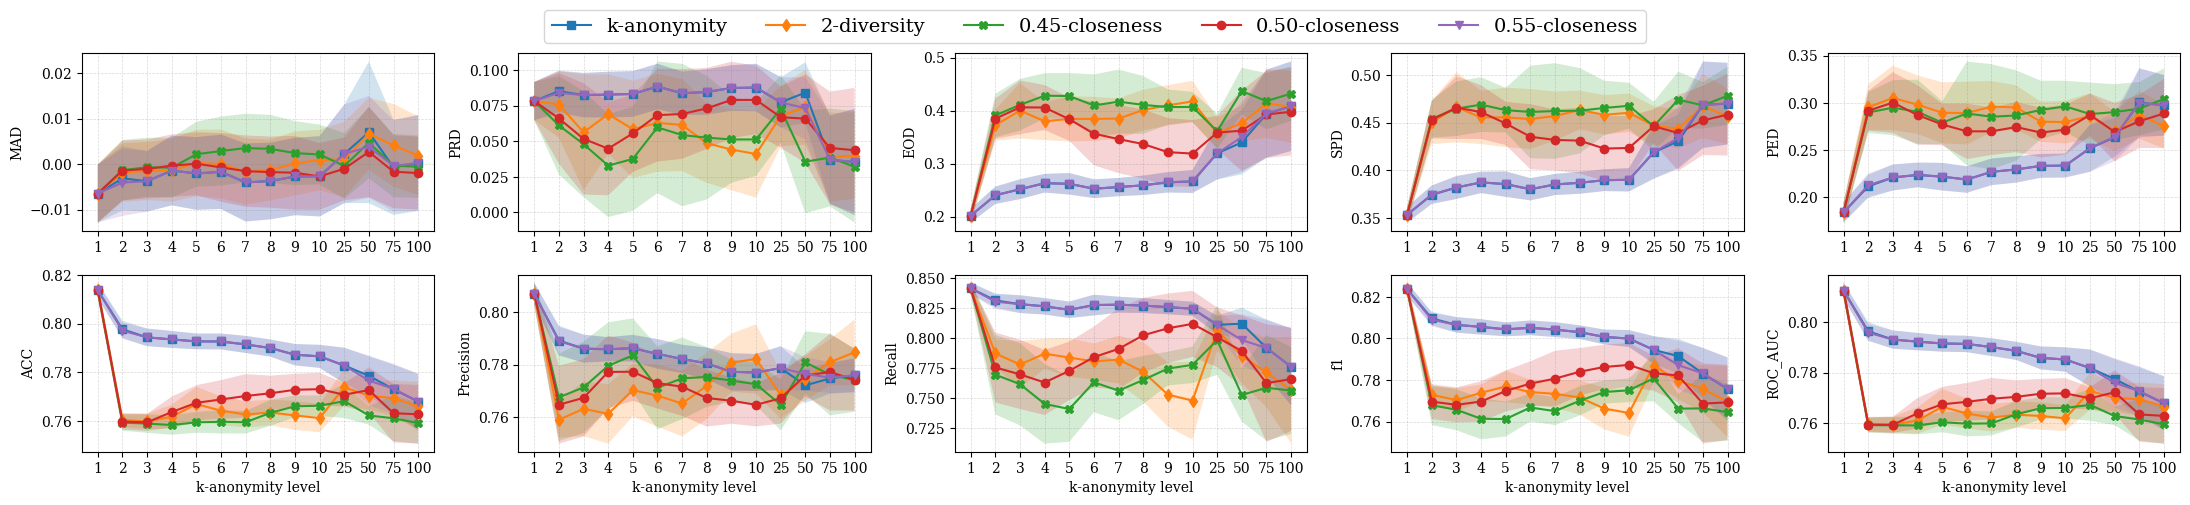

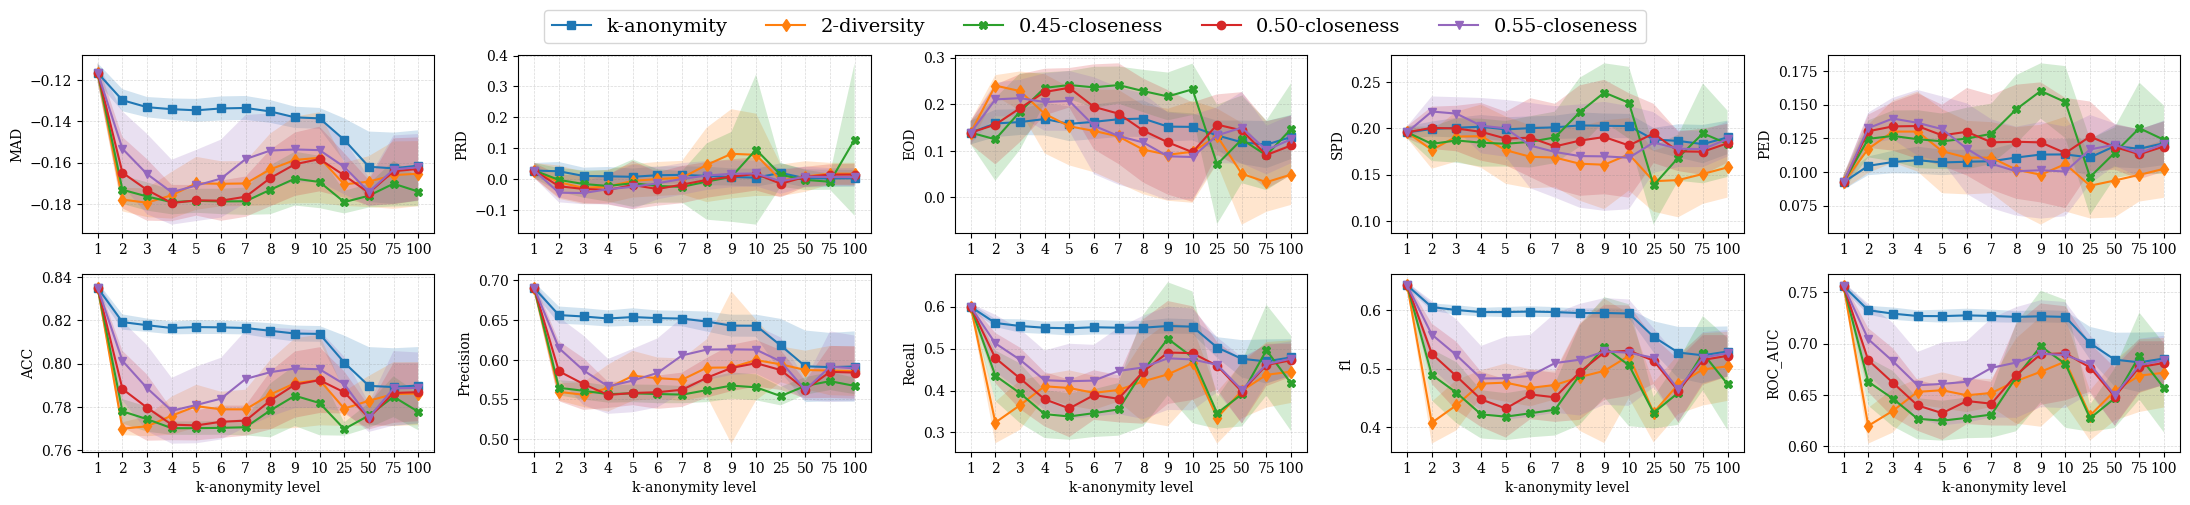

In [3]:
# Load dataset
results_df = pd.read_csv("results//anonymity_impact_fairness.csv")

# Sanitize data to ensure metrics are within expected ranges
metrics = ["Precision", "Recall", "f1"]
for metric in metrics:
    # Convert columns to numeric and ensure values are between 0 and 1
    results_df[metric] = pd.to_numeric(results_df[metric], errors='coerce')  # Force conversion to numeric
    results_df[metric] = results_df[metric].apply(lambda x: x / 100 if x > 1 else x)  # Adjust values > 1
    results_df[metric] = results_df[metric].apply(lambda x: x if 0 <= x <= 1 else np.nan)  # Keep only valid values

# Define the metrics to plot
plot_metrics = ["MAD", "PRD", "EOD", "SPD", "PED", "ACC", "Precision", "Recall", "f1", "ROC_AUC"]

# Define fixed values for parameters
dataset = 'adult'
protected_att = 'gender'
lst_k = cfg.lst_k
l_div = cfg.l_div
lst_t = cfg.lst_t
lst_threshold_target = cfg.adult_threshold_target


for threshold_target in lst_threshold_target:
        
    # Collect handles and labels for the legend
    handles, labels = [], []
    legend_added = set()
    # Initialize plot
    plt.figure(figsize=(22, 5))

    for i, metric in enumerate(plot_metrics, 1):
        plt.subplot(2, 5, i)  # Arrange plots in a 2x5 grid
        
        idx_marker = 0
        for method in ['k-anonymity', 'l-diversity', 't-closeness']:
            if method == 'k-anonymity':
                filtered_df = results_df[
                    (results_df['dataset'] == dataset + "_" + str(threshold_target)) &
                    (results_df['protected_att'] == protected_att) &
                    (results_df['method'] == 'k-anonymity') &
                    (results_df['k_parameter'].isin(lst_k))
                ]
                label = 'k-anonymity'
            
            elif method == 'l-diversity':
                filtered_df = results_df[
                    (results_df['dataset'] == dataset + "_" + str(threshold_target)) &
                    (results_df['protected_att'] == protected_att) &
                    (results_df['method'] == 'l-diversity') &
                    (results_df['k_parameter'].isin(lst_k)) &
                    (results_df['anon_parameter'] == l_div)
                ]
                label = f'{l_div}-diversity'
            
            elif method == 't-closeness':
                for t_val in lst_t:
                    filtered_df = results_df[
                        (results_df['dataset'] == dataset + "_" + str(threshold_target)) &
                        (results_df['protected_att'] == protected_att) &
                        (results_df['method'] == 't-closeness') &
                        (results_df['k_parameter'].isin(lst_k)) &
                        (results_df['anon_parameter'] == t_val)
                    ]

                    # Aggregate and plot for t_closeness
                    agg_results = filtered_df.groupby('k_parameter')[metric].agg(['mean', 'std']).reindex(lst_k).reset_index()
                    means = agg_results['mean']
                    stds = agg_results['std']
                    
                    # Only add to legend if not already added
                    if (method, t_val) not in legend_added:
                        line, = plt.plot(range(len(lst_k)), means, marker=markers[idx_marker], label=f'{float(t_val):.2f}-closeness')
                        legend_added.add((method, t_val))  # Mark as added to legend
                    else:
                        plt.plot(range(len(lst_k)), means, marker=markers[idx_marker])
                        
                    plt.fill_between(range(len(lst_k)), means - stds, means + stds, alpha=0.2)
                    idx_marker += 1
                continue  # Skip to the next metric for t-closeness

            # Aggregate results for k-anonymity and l-diversity
            agg_results = filtered_df.groupby('k_parameter')[metric].agg(['mean', 'std']).reindex(lst_k).reset_index()
            means = agg_results['mean']
            stds = agg_results['std']
            
            # Plot mean and shaded area for standard deviation
            if (method, None) not in legend_added:
                line, = plt.plot(range(len(lst_k)), means, marker=markers[idx_marker], label=label)
                legend_added.add((method, None))  # Mark as added to legend
            else:
                plt.plot(range(len(lst_k)), means, marker=markers[idx_marker])
                
            plt.fill_between(range(len(lst_k)), means - stds, means + stds, alpha=0.2)
            idx_marker += 1

        # Set labels and title for each subplot
        if i >= 6:
            plt.xlabel("k-anonymity level")
        plt.ylabel(metric)
        plt.grid(True, alpha=0.3, color='gray', linestyle='--', linewidth=0.5)
        plt.xticks(range(len(lst_k)), lst_k)

    # Add a single legend above all plots
    plt.figlegend(loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1.02), fontsize=14)

    # Adjust layout and display plot
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


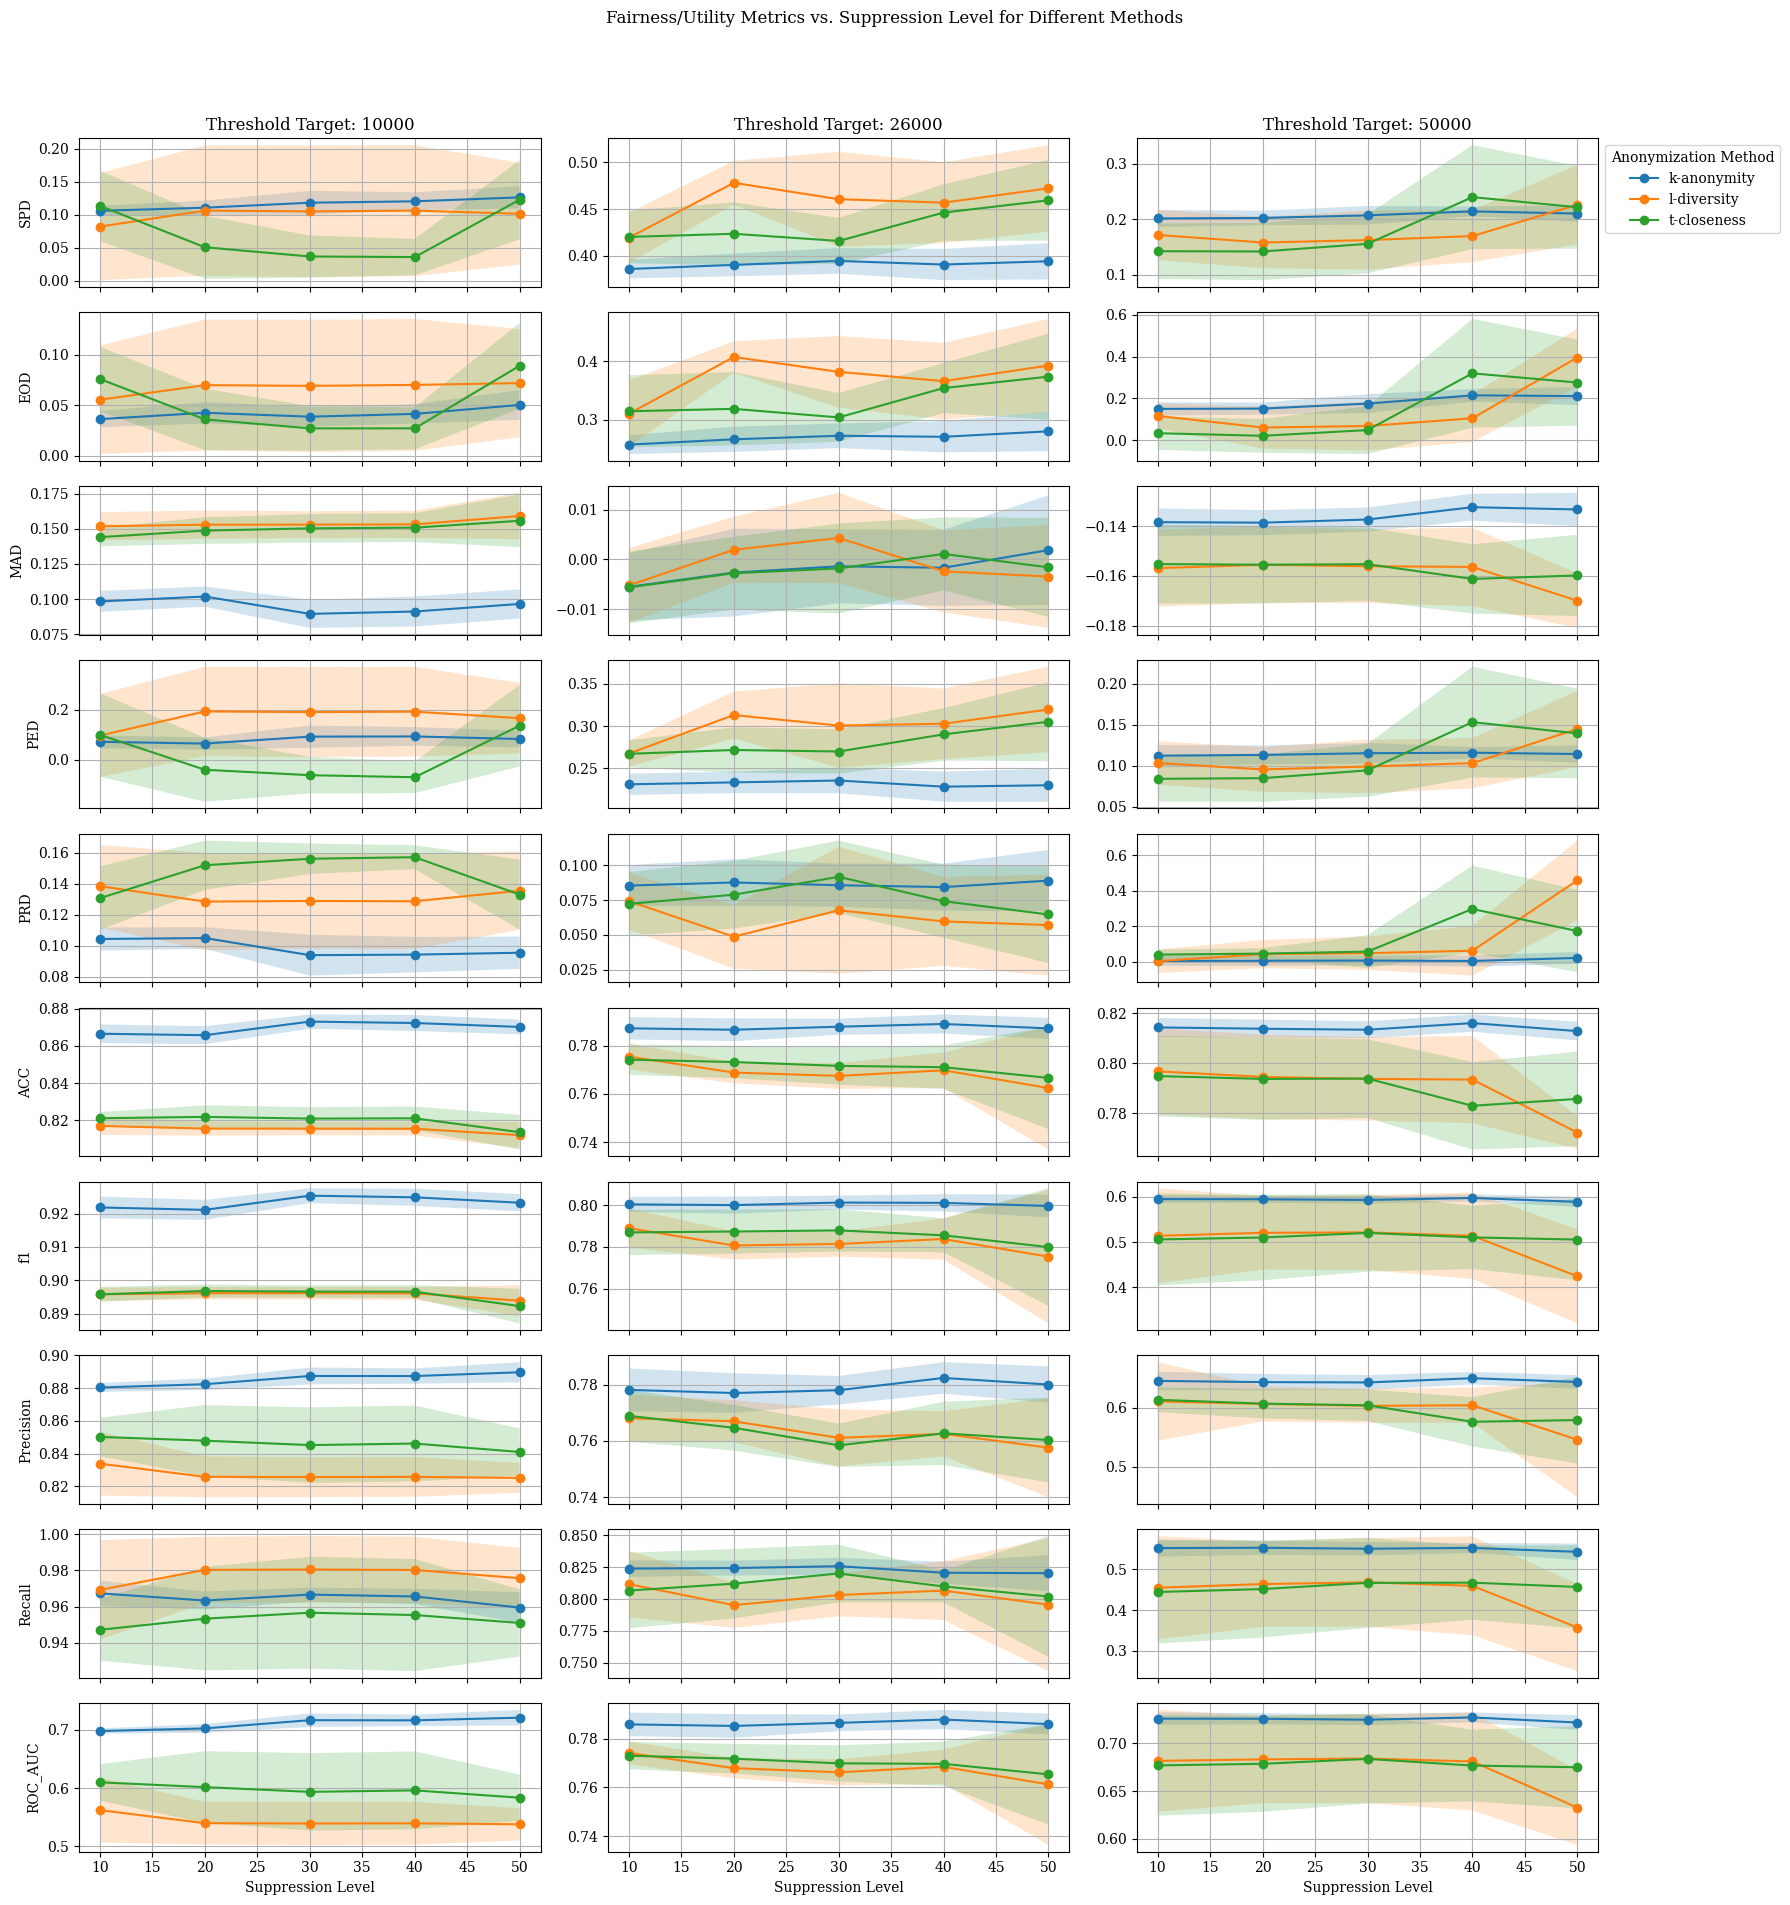

In [4]:
# Load and filter results by dataset and threshold target
results_df = pd.read_csv("results/anonymity_impact_fairness_suppression.csv")
dataset = 'adult'

# Define metrics to plot and other plotting parameters
metrics = ["SPD", "EOD", "MAD", "PED", "PRD", "ACC", "f1", "Precision", "Recall", "ROC_AUC"]

threshold_targets = cfg.adult_threshold_target
lst_supp_level = cfg.supp_level

# Initialize the plot layout
fig, axes = plt.subplots(len(metrics), len(threshold_targets), figsize=(18, 20), sharex=True)
fig.suptitle("Fairness/Utility Metrics vs. Suppression Level for Different Methods")

for col_idx, threshold_target in enumerate(threshold_targets):
    filtered_df = results_df[results_df['dataset'] == f"{dataset}_{threshold_target}"]
    
    for row_idx, metric in enumerate(metrics):
        ax = axes[row_idx, col_idx]
        
        # Loop over anonymization methods
        for method in ['k-anonymity', 'l-diversity', 't-closeness']:
            method_df = filtered_df[filtered_df['method'] == method]

            # Group by suppression level and compute mean and std for each metric
            agg_results = method_df.groupby('supp_level')[metric].agg(['mean', 'std']).reindex(lst_supp_level)
            means = agg_results['mean']
            stds = agg_results['std']
            
            # Plot with shaded area for standard deviation
            ax.plot(lst_supp_level, means, marker='o', label=f"{method}")
            ax.fill_between(lst_supp_level, means - stds, means + stds, alpha=0.2)
        
        # Labeling
        ax.set_title(f"Threshold Target: {threshold_target}" if row_idx == 0 else "")
        ax.set_ylabel(metric if col_idx == 0 else "")
        ax.grid(True)

# General plot settings
for ax in axes[-1, :]:
    ax.set_xlabel("Suppression Level")
axes[0, -1].legend(title="Anonymization Method", loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
